In [1]:
import numpy as np
from icecream import ic

In [2]:
problem = np.load('problem_0.npz')
x = problem['x']
y = problem['y']
x.shape

(2, 1000)

In [3]:
from gxgp import Node

input = x
labels = y

#Single input and output
print(input.shape, labels.shape)
#Print a column of input
print("INPUT")
print(input[:,0])
print("LABEL")
print(labels[0])
#Functional set
from operations.operations_dict import basic_function_set, complex_function_set

functional_set = {**basic_function_set, **complex_function_set}

# Terminal set
terminal_list = ['x' + str(i) for i in range(input.shape[0])]

print(terminal_list)

(2, 1000) (1000,)
INPUT
[ 2.37857096 -0.74681473]
LABEL
2.242710018984468
['x0', 'x1']


## Tree Generation  

In [15]:
import random


def generate_random_tree(max_depth, basic_function_set, complex_function_set, pc,terminal_set):
    if max_depth == 0 or (random.random() < 0.3):  # Terminale con probabilità
        terminal = random.choice(terminal_set)
        return Node(terminal)
    else:
        if random.random() < pc:
            func = random.choice(list(complex_function_set.keys()))
            num_children = complex_function_set[func].__code__.co_argcount  # Numero di argomenti della funzione
            children = [generate_random_tree(max_depth - 1, basic_function_set, complex_function_set, pc,terminal_set)
                        for _ in range(num_children)]
            return Node(complex_function_set[func], children,name=func)
        else:
            func = random.choice(list(basic_function_set.keys()))
            num_children = basic_function_set[func].__code__.co_argcount  # Numero di argomenti della funzione
            children = [generate_random_tree(max_depth - 1, basic_function_set, complex_function_set, pc,terminal_set)
                        for _ in range(num_children)]
            return Node(basic_function_set[func], children,name=func)
        


## Generation

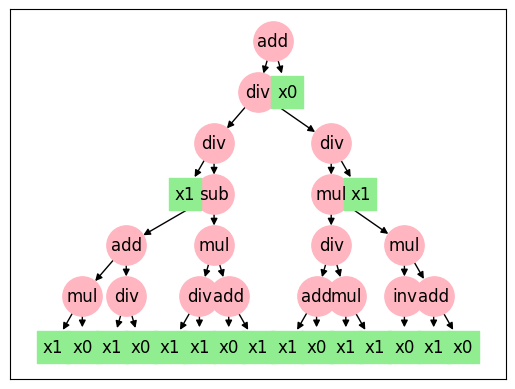

In [16]:
mytree = generate_random_tree(6, basic_function_set,complex_function_set, 0.05, terminal_list)
mytree.draw()